In [79]:
import numpy as np
import networkx as nx
import time
import random
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Generating the adjacency matrix

In [35]:
def generate_adjacency_matrix(vertices, edges):
    matrix = np.zeros((vertices, vertices), dtype=int)
    possible_edges = []
    for i in range(vertices):
        for j in range(i + 1, vertices):
            possible_edges.append((i, j))
    selected_edges = np.random.choice(len(possible_edges), edges, replace=False)
    for edge_idx in selected_edges:
        i, j = possible_edges[edge_idx]
        weight = np.random.randint(1, 101)
        matrix[i, j] = matrix[j, i] = weight
    return matrix    

### Creating the function for Dijkstra's and Bellman-Ford algorithms
Also adding the function calculating the average time

In [137]:
def dijkstra_network(adj_matrix, start_node):
    G = nx.from_numpy_array(adj_matrix)
    return nx.single_source_dijkstra_path_length(G, start_node)

def bellman_ford_network(adj_matrix, start_node):
    G = nx.DiGraph()
    n = len(adj_matrix)
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] > 0:
                G.add_edge(i, j, weight=adj_matrix[i, j])
    if start_node is None:
        start_node = np.random.randint(0, n)
    try:
        return nx.single_source_bellman_ford_path_length(G, start_node)
    except nx.NetworkXUnbounded:
        return None
    except Exception:
        return None

def avg_time(algorithm, adj_matrix):
    
    start_node = np.random.randint(0, len(adj_matrix))
    times=[]
    for i in range(10):
        start_time=time.perf_counter()
        if algorithm=='Dijkstra':
            shortest_paths = dijkstra_network(adj_matrix, start_node)
        elif algorithm=='Bellman-Ford':
            shortest_paths = bellman_ford_network(adj_matrix, start_node)
        else:
            return 'Unknown algorithm'
        stop_time=time.perf_counter()
        all_time=stop_time-start_time
        times.append(all_time)
        
    if not times:
        return 0.0
    
    return np.mean(times)   

In [139]:
vertices = 100
edges = 500
matrix = generate_adjacency_matrix(vertices, edges)
avg_time_dijkstra = avg_time('Dijkstra', matrix)
print(f"Average time for Dijkstra's algorithm: {avg_time_dijkstra:.6f} seconds")
avg_time_bellman_ford = avg_time('Bellman-Ford', matrix)
print(f"Average time for Bellman-Ford algorithm: {avg_time_bellman_ford:.6f} seconds")

Average time for Dijkstra's algorithm: 0.004516 seconds
Average time for Bellman-Ford algorithm: 0.007618 seconds


Here we can see that Dijkstra's algorithm is a bit faster, the the difference is not very strong. It can be caused by the small size of the graph.

### Creating the grid and the A* search algorithm

In [121]:
def generate_grid(rows, cols, num_obstacles):
    grid = np.zeros((rows, cols), dtype=int)
    all_cells = [(i, j) for i in range(rows) for j in range(cols)]
    obstacle_cells = random.sample(all_cells, num_obstacles)
    for cell in obstacle_cells:
        grid[cell[0], cell[1]] = 1
    return grid

def get_two_free_cells(grid):
    free_cells = []
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] == 0:
                free_cells.append((i, j))

    if len(free_cells)<2:
        return 'Not enough free cells'

    selected_indices = np.random.choice(len(free_cells), 2, replace=False)
    start = free_cells[selected_indices[0]]
    goal = free_cells[selected_indices[1]]
    
    return start, goal

class Node:
    # A class for representing a node in the algorithm A*
    def __init__(self, position: Tuple[int, int], parent=None):
        self.position = position
        self.parent = parent
        self.g = 0  # he cost of the path from the start to this cell
        self.h = 0  # heuristic estimation to the goal
        self.f = 0  # total cost: f = g + h
    
    def __eq__(self, other):
        return self.position == other.position
    
    def __lt__(self, other):
        return self.f < other.f
    
    def __hash__(self):
        return hash(self.position)

def a_star_search(grid, start, end):
    
    if not is_valid_cell(grid, start) or not is_valid_cell(grid, end):
        return None, None
    if grid[start[0]][start[1]] == 1 or grid[end[0]][end[1]] == 1:
        return None, None
    start_node = Node(start)
    end_node = Node(end)
    open_list = []
    closed_set = set()
    heapq.heappush(open_list, start_node)
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    while open_list:
        # getting the node with the lowest cost f
        current_node = heapq.heappop(open_list)
        
        # If the goal is reached, restore the path and calculate the length
        if current_node.position == end_node.position:
            path = reconstruct_path(current_node)
            path_length = len(path) - 1  
            return path, path_length
        
        # Adding the current node to the closed list
        closed_set.add(current_node.position)
        
        # Checking all neighbours 
        for direction in directions:
            neighbor_pos = (current_node.position[0] + direction[0], 
                          current_node.position[1] + direction[1])
            if not is_valid_cell(grid, neighbor_pos) or grid[neighbor_pos[0]][neighbor_pos[1]] == 1:
                continue
            
            # If the neighbour is in the closed list, skip
            if neighbor_pos in closed_set:
                continue
            
            # Set the node of the neighbour
            neighbor_node = Node(neighbor_pos, current_node)
            
            # Calculating the cost
            neighbor_node.g = current_node.g + 1 
            neighbor_node.h = manhattan_distance(neighbor_pos, end_node.position)
            neighbor_node.f = neighbor_node.g + neighbor_node.h
            
            # Checking if there is a neighbor in the open list with the best cost.
            if any(open_node.position == neighbor_pos and open_node.f <= neighbor_node.f for open_node in open_list):
                continue
            
            # Adding the neighbour into the open list
            heapq.heappush(open_list, neighbor_node)
    
    # If there is no path
    return None, None

def is_valid_cell(grid, pos):
    row, col = pos
    return 0 <= row < len(grid) and 0 <= col < len(grid[0])

def manhattan_distance(pos1, pos2) :
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def reconstruct_path(node):
    path = []
    current = node
    while current is not None:
        path.append(current.position)
        current = current.parent
    return path[::-1] 

### Adding visualisation function and ta repetition function for analysis

In [131]:
def visualize_path(grid,start, end, path):
    grid_array = np.array(grid)
    rows, cols = grid_array.shape
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)
    for i in range(rows):
        for j in range(cols):
            if grid_array[i, j] == 1:
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, edgecolor='gray', facecolor='gray', alpha=0.3)
                ax.add_patch(rect)
    if path:
        path_y, path_x = zip(*path) 
        ax.plot(path_x, path_y, 'b-',  alpha=0.5, label='Path')
        ax.plot(path_x, path_y, 'b-', alpha=0.5)

    start_y, start_x = start
    ax.plot(start_x, start_y, 'bo', label='Start')

    end_y, end_x = end
    ax.plot(end_x, end_y, 'go', label='End')
    
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_xticks(np.arange(0, cols, 1))
    ax.set_yticks(np.arange(0, rows, 1))
    ax.set_xticklabels(np.arange(0, cols, 1))
    ax.set_yticklabels(np.arange(0, rows, 1))
    ax.set_xlim(-0.5, cols-0.5)
    ax.set_ylim(rows-0.5, -0.5) 
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title('A* path search')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def a_star_analisys(grid):
    for i in range(5):
        free_cells = get_two_free_cells(grid)
        if free_cells is not None:
            start, goal = free_cells
            start_time = time.perf_counter()
            path, length = a_star_search(grid, start, goal)
            all_time = time.perf_counter() - start_time
            print(f"The start point is {start}\nThe goal point is {goal}\nThe shortest path is {length}\nProcessing time is {all_time:.6f} seconds")
            visualize_path(grid,start, goal, path)            

### Results
There are the results below.

The start point is (7, 4)
The goal point is (4, 3)
The shortest path is 4
Processing time is 0.000208 seconds


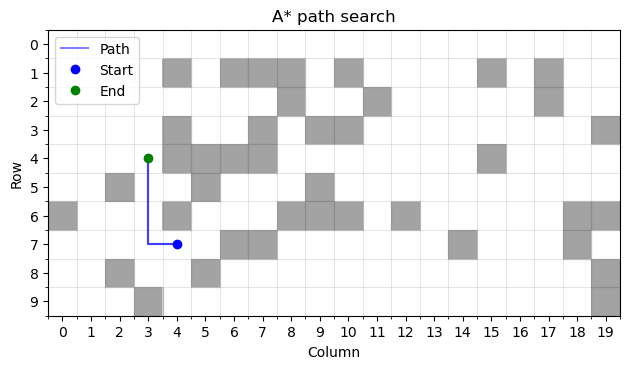

The start point is (7, 19)
The goal point is (0, 16)
The shortest path is None
Processing time is 0.000031 seconds


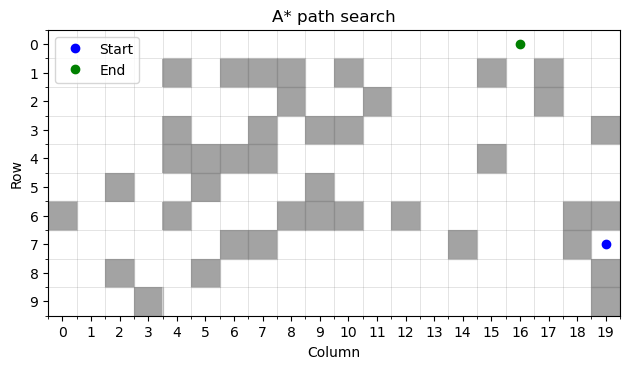

The start point is (9, 13)
The goal point is (9, 4)
The shortest path is 9
Processing time is 0.000215 seconds


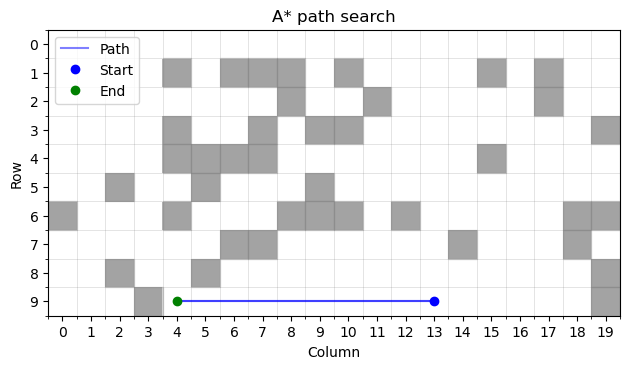

The start point is (7, 0)
The goal point is (0, 12)
The shortest path is 19
Processing time is 0.002066 seconds


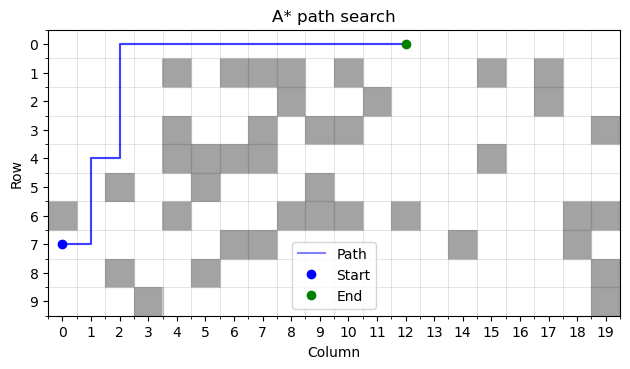

The start point is (9, 16)
The goal point is (7, 12)
The shortest path is 6
Processing time is 0.000481 seconds


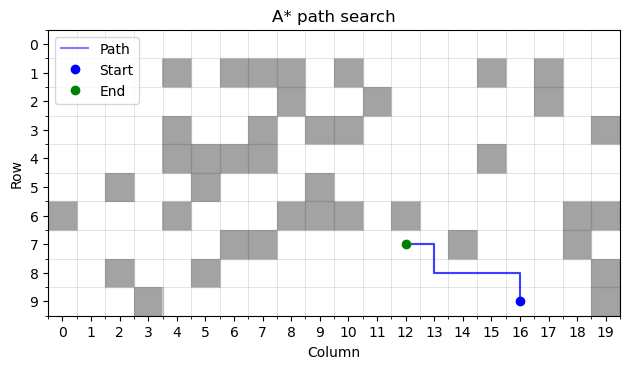

In [133]:
rows = 10
cols = 20
num_obstacles = 40

grid = generate_grid(rows, cols, num_obstacles)
a_star_analisys(grid)

### Data structuries:
1. Two-dimensional arrays and matricies for representing graphs and spatial data
2. Minimal heap for efficient extraction of the node with the lowest cost for A* algorithm
3. Set for tracking visited nodes in A*
4. Lists for storing the restored path and measurement results, for a collection of free cells
### Design techniques:
1. Combining data and behavior in the Node class
2. Functional decomposition
3. Heuristic search (A*): combination: actual cost heuristic estimate
4. Heuristic: Manhattan distance for grids
5. Restoring the path through parent links
